In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os
from torchmetrics import F1Score

In [2]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
train_dir_path = '../../input/data/train/'
train_image_path = '../../input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
dt_train

,id,gender,race,age,path
0,1,female,Asian,45,000001_female_Asian_45
1,2,female,Asian,52,000002_female_Asian_52
2,4,male,Asian,54,000004_male_Asian_54
3,5,female,Asian,58,000005_female_Asian_58
4,6,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,6954,male,Asian,19,006954_male_Asian_19
2696,6955,male,Asian,19,006955_male_Asian_19
2697,6956,male,Asian,19,006956_male_Asian_19
2698,6957,male,Asian,20,006957_male_Asian_20


In [4]:
def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2

In [5]:
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))

In [6]:
dt_train

,id,gender,race,age,path,age_range
0,1,female,Asian,45,000001_female_Asian_45,1
1,2,female,Asian,52,000002_female_Asian_52,1
2,4,male,Asian,54,000004_male_Asian_54,1
3,5,female,Asian,58,000005_female_Asian_58,1
4,6,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
2695,6954,male,Asian,19,006954_male_Asian_19,0
2696,6955,male,Asian,19,006955_male_Asian_19,0
2697,6956,male,Asian,19,006956_male_Asian_19,0
2698,6957,male,Asian,20,006957_male_Asian_20,0


In [7]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])

In [8]:
train_image = []
train_label = []

for idx in train_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        _, file_extension = os.path.splitext(file_name)
        if file_extension not in ['.jpg', '.jpeg', '.png']:
            continue
        train_image.append(train_image_path+path+'/'+file_name)
        train_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))   

In [9]:
valid_image = []
valid_label = []

for idx in valid_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        _, file_extension = os.path.splitext(file_name)
        if file_extension not in ['.jpg', '.jpeg', '.png']:
            continue
        valid_image.append(train_image_path+path+'/'+file_name)
        valid_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))   

In [10]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [11]:
train_data = pd.Series(train_image)
train_label = pd.Series(train_label)

valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [12]:
class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data
        self.label = label
        self.transform = transform
        
        if encoding:
            self.label = self.label.apply(onehot_enc)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.midcrop:
            X = X[70:420, 17:367]
        
        if self.transform:
            return self.transform(X), y
        return X, y

In [13]:
mask_train_set = Dataset_Mask(data=train_data, label=train_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [14]:
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [15]:
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 15120
validation data size : 3780


In [16]:
batch_size = 1

train_dataloader_mask = DataLoader(dataset = mask_train_set, drop_last=True, batch_size=batch_size, num_workers=4)
val_dataloader_mask = DataLoader(dataset = mask_val_set, drop_last=True, batch_size=batch_size, num_workers=4)

In [17]:
#basemodel_resnet34 = torchvision.models.resnet34(pretrained=True)
#basemodel_resnet34 = torch.load('resnet50_kfold_checkpoint_best.pth')
basemodel_resnet34 = torch.load('checkpoint_best.pt')
#for p_idx, (param_name, param) in enumerate(basemodel_resnet34.named_parameters()):
#    print(param_name)

In [18]:
class_num = 18

fc_features = {}

def get_features(name):
    def hook(model, input, output):
        fc_features[name] = output.detach()
    return hook

for l_idx, (layer_name, layer) in enumerate(basemodel_resnet34._modules.items()):
    if layer_name == 'avgpool':
        layer.register_forward_hook(get_features('avgpool'))

In [19]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(basemodel_resnet34.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

Total number of parameters:[23,544,914].


In [20]:
from sklearn.manifold import TSNE
import seaborn as sns

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

def get_representations(model, iterator):
    model.eval()

    features = np.ndarray((1, 2048))
    labels = np.ndarray((1))
    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            output = model.forward(x)
            features = np.concatenate((features, fc_features['avgpool'].reshape(1,2048).cpu().numpy()))
            labels = np.concatenate((labels, y.numpy()))
            #np.concatenate(fc_features['module.fc'])

    return features[1:], labels[1:]

def get_tsne(data, n_components = 2):
    tsne = TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data


def plot_representations(data, labels, n_images = ['O:M:20', 'O:M:45', 'O:M:60',
                'O:F:20', 'O:F:45', 'O:F:60',
                '-:M:20', '-:M:45', '-:M:60',
                '-:F:20', '-:F:45', '-:F:60',
                ' :M:20', ' :M:45', ' :M:60',
                ' :F:20', ' :F:45', ' :F:60']):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')

using cuda:0


In [22]:
features, labels = get_representations(basemodel_resnet34, val_dataloader_mask)
output_tsne_data = get_tsne(features)

  0%|          | 0/3780 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


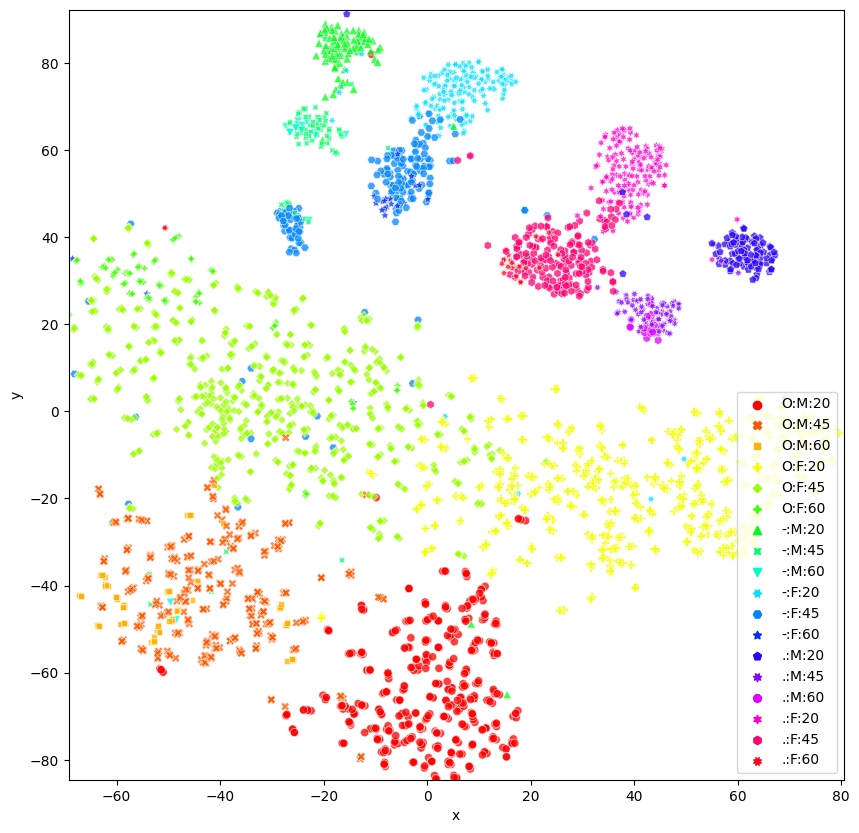

In [23]:
colors = ["#FF7FFF", "#FF7F7F", "#FF7F00",
          "#FF00FF", "#FF007F", "#FF0000",
          "#7F7FFF", "#7F7F7F", "#7F7F00",
          "#7F00FF", "#7F007F", "#7F0000",
          "#007FFF", "#007F7F", "#007F00",
          "#0000FF", "#00007F", "#000000"]

n_images = ['O:M:20', 'O:M:45', 'O:M:60',
            'O:F:20', 'O:F:45', 'O:F:60',
            '-:M:20', '-:M:45', '-:M:60',
            '-:F:20', '-:F:45', '-:F:60',
            '.:M:20', '.:M:45', '.:M:60',
            '.:F:20', '.:F:45', '.:F:60']

plt.figure(figsize=(10,10))
plt.xlim(output_tsne_data[:,0].min(), output_tsne_data[:,0].max()+1)
plt.ylim(output_tsne_data[:,1].min(), output_tsne_data[:,1].max()+1)
#for i in range(len(labels)):
#    plt.text(output_tsne_data[i,0], output_tsne_data[i,1], n_images[labels[i]],
#             color = colors[labels[i]])

tsne_df = pd.DataFrame({'x': output_tsne_data[:, 0], 'y':output_tsne_data[:, 1], 'classes':labels})
ax = sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    style = 'classes',
    palette = 'hsv',
    data = tsne_df,
    legend = "full",
    alpha = 0.75
)

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, n_images, loc='lower right')